# Import

In [15]:
# Basic
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore', category=UserWarning)

# Dataset
from sklearn.datasets import make_moons, load_boston

# ML Toolkit
from robusta.crossval import crossval, rating_table

# Model
from robusta.calibration import CalibratedClassifierCV
from robusta.testing import all_models

# Plot
from jupyterthemes import jtplot
import seaborn as sns
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

# Correlations

In [2]:
def plot_corr_matrix(results, cmap='icefire', method='kendall', n_digits=2, **kwargs):
    
    idx_list = results.keys()
    model_names = [result['model_name'] for result in results.values()]
    for idx, model_name in zip(idx_list, model_names):
        print('[{}] {}'.format(idx, model_name))
    
    preds = [result['oof_pred'] for result in results.values()]
    preds = pd.concat(preds, axis=1)
    preds.columns = idx_list

    corr = preds.corr(method).round(n_digits)
    corr = corr.groupby(corr.index).mean().loc[idx_list]
    
    ax = sns.heatmap(corr, annot=True, cmap=cmap, center=0, **kwargs)
    return ax

# All Classifiers

In [3]:
X, y = make_moons(200, noise=0.2)

X = pd.DataFrame(X)
y = pd.Series(y)

X

,0,1
0,-0.998108,-0.270837
1,0.345627,0.095435
2,0.269236,-0.369720
3,0.733658,0.116887
4,0.919405,-0.019487
...,...,...
195,-0.017089,-0.124368
196,1.053936,0.204152
197,-0.811449,0.773323
198,-0.180742,0.849066


In [4]:
scoring = 'roc_auc'
cv = 5

In [5]:
BLACKLIST = ['RVM', 'Blend', 'CatBoost']

results = {}

for model_dict in all_models(['classifier']):
    
    try:
        clf = model_dict['class']() # default params
        name = model_dict['name']
    except:
        continue
    
    if name in BLACKLIST:
        continue
    
    if not hasattr(clf, 'predict_proba'):
        if hasattr(clf, 'decision_function'):
            clf = CalibratedClassifierCV(clf)
        else:
            continue
    
    try:
        result = crossval(clf, cv, X, y, scoring=scoring, method='predict_proba',
                          verbose=0, n_jobs=-1)
        result['model_name'] = name
        results[name] = result
        
        scores = result['score']
        print('  '.join(['{:.4f}'.format(s) for s in scores]), end=' '*4)
        print('{:.4f} ± {:.4f}'.format(np.mean(scores), np.std(scores)), end=' '*4)
        print(f'[{name}]')
        
    except:
        pass
    
idx_results = dict(zip(range(len(results)), results.values()))

0.9000  0.9575  0.9650  0.9300  0.9325    0.9370 ± 0.0230    [LogisticRegression]
0.8975  0.9575  0.9675  0.9350  0.9450    0.9405 ± 0.0242    [LogisticRegressionCV]
0.8950  0.9575  0.9600  0.9325  0.9275    0.9345 ± 0.0236    [PassiveAggressive]
0.8850  0.9525  0.9600  0.9250  0.9250    0.9295 ± 0.0264    [Perceptron]
0.9000  0.9575  0.9650  0.9300  0.9375    0.9380 ± 0.0229    [Ridge]
0.9000  0.9575  0.9650  0.9300  0.9375    0.9380 ± 0.0229    [RidgeCV]
0.9025  0.9525  0.9575  0.9275  0.9400    0.9360 ± 0.0197    [SGD]
0.9675  0.9925  0.9950  0.9825  0.9975    0.9870 ± 0.0110    [SVM]
0.9675  0.9925  0.9950  0.9825  0.9975    0.9870 ± 0.0110    [NuSVM]
0.9675  0.9925  0.9950  0.9825  0.9975    0.9870 ± 0.0110    [LinearSVM]
0.9000  0.9600  0.9700  0.9325  0.9375    0.9400 ± 0.0243    [LDA]
0.8975  0.9600  0.9625  0.9325  0.9375    0.9380 ± 0.0235    [QDA]
1.0000  1.0000  1.0000  0.9750  1.0000    0.9950 ± 0.0100    [KNeighbors]
0.9475  0.9825  0.9925  0.9650  0.9825    0.9740 ± 0.01

In [6]:
top = rating_table(idx_results).sort_values('LOCAL', ascending=False)
top

,MODEL_NAME,PRIVATE,PUBLIC,LOCAL,STD,MIN,MAX
12,KNeighbors,None,None,0.9950,0.0112,0.9750,1.0000
15,ExtraTrees,None,None,0.9940,0.0060,0.9862,0.9988
22,LGB,None,None,0.9935,0.0074,0.9825,1.0000
14,RandomForest,None,None,0.9935,0.0071,0.9812,1.0000
18,AdaBoost,None,None,0.9918,0.0117,0.9750,1.0000
21,XGB,None,None,0.9900,0.0074,0.9812,1.0000
17,GradientBoosting,None,None,0.9900,0.0109,0.9738,1.0000
16,Bagging,None,None,0.9870,0.0167,0.9675,1.0000
7,SVM,None,None,0.9870,0.0123,0.9675,0.9975
8,NuSVM,None,None,0.9870,0.0123,0.9675,0.9975


[12] KNeighbors
[15] ExtraTrees
[22] LGB
[14] RandomForest
[18] AdaBoost
[21] XGB
[17] GradientBoosting
[16] Bagging
[7] SVM
[8] NuSVM


<IPython.core.display.Javascript object>


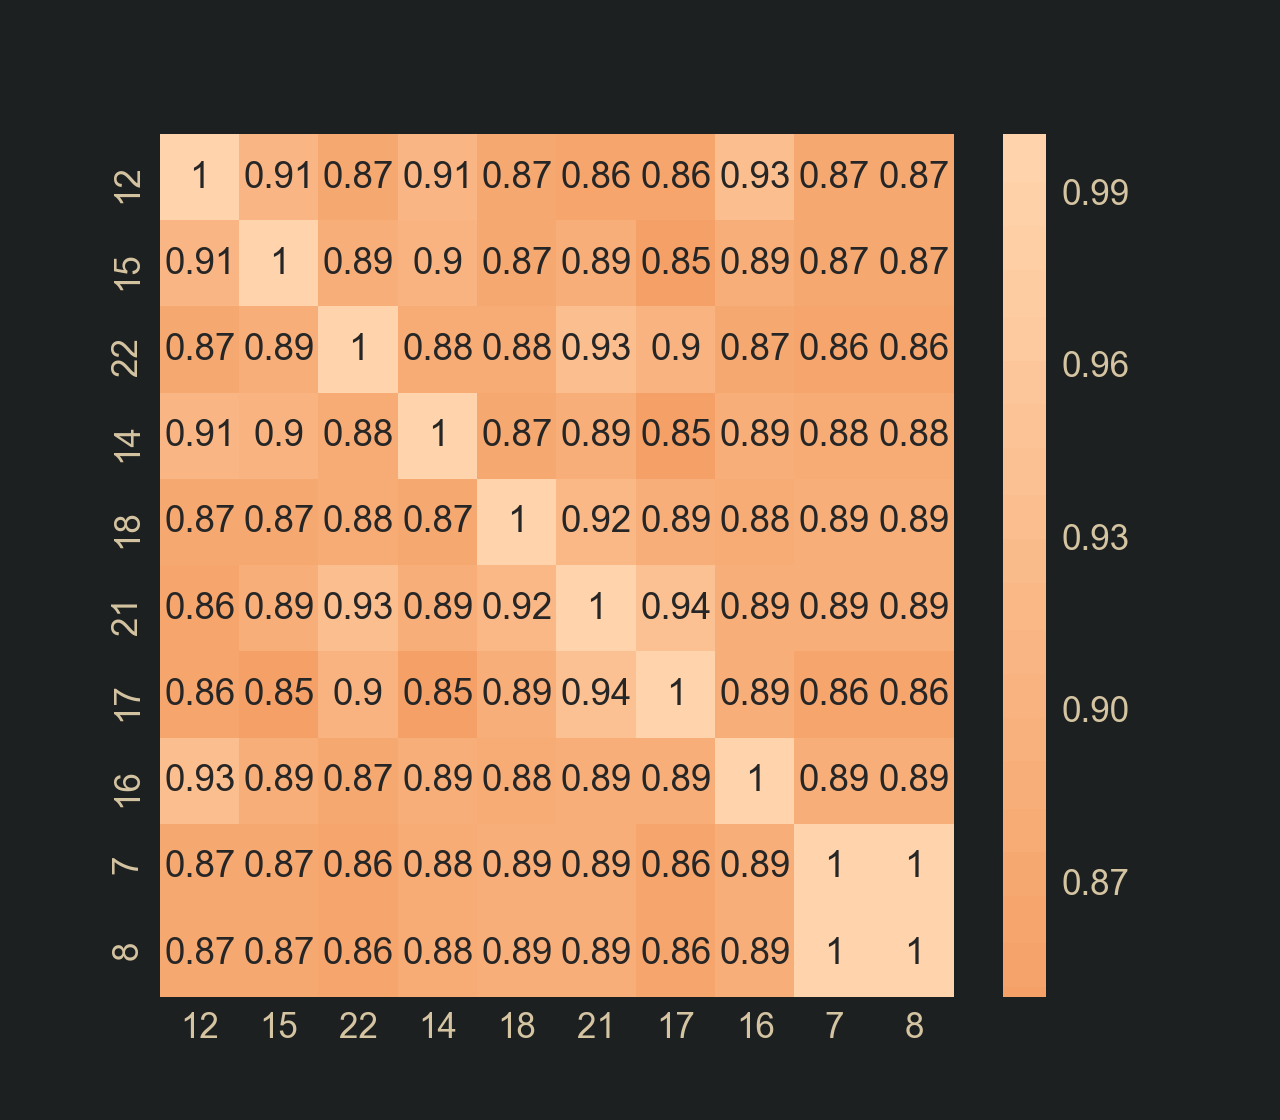

In [7]:
%matplotlib notebook

K_TOP = 10

top_results = {i: idx_results[i] for i in top.index[:K_TOP]}
ax = plot_corr_matrix(top_results, method='spearman')

# All Regressors

In [8]:
X, y = load_boston(return_X_y=True)

X = pd.DataFrame(X)
y = pd.Series(y)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [9]:
scoring = 'neg_mean_squared_error'
cv = 5

In [16]:
BLACKLIST = ['RVM', 'Blend', 'CatBoost', 'RANSAC', 'SGD', 'BART']

results = {}

for model_dict in all_models(['regressor']):
    
    try:
        reg = model_dict['class']() # default params
        name = model_dict['name']
    except:
        continue
    
    if name in BLACKLIST or 'MultiTask' in name:
        continue
    
    try:
        result = crossval(reg, cv, X, y, scoring=scoring, method='predict',
                          verbose=0, n_jobs=-1)
        result['model_name'] = name
        results[name] = result
        
        scores = result['score']
        print('  '.join(['{:.4f}'.format(s) for s in scores]), end=' '*4)
        print('{:.4f} ± {:.4f}'.format(np.mean(scores), np.std(scores)), end=' '*4)
        print(f'[{name}]')
        
    except:
        pass
    
idx_results = dict(zip(range(len(results)), results.values()))

-12.0781  -27.9411  -34.6298  -82.4508  -30.0944    -37.4388 ± 23.7541    [ARDRegression]
-11.5812  -24.7569  -30.5592  -79.6687  -28.3731    -34.9878 ± 23.2907    [BayesianRidge]
-14.8425  -30.7088  -47.7941  -47.4693  -19.4537    -32.0537 ± 13.7273    [ElasticNet]
-18.7250  -33.2299  -56.1521  -47.0278  -19.7299    -34.9729 ± 14.7869    [ElasticNetCV]
-9.3535  -74.6249  -58.5727  -70.7502  -92.2983    -61.1199 ± 28.0481    [Huber]
-16.7026  -26.0486  -33.0741  -80.7624  -33.3136    -37.9803 ± 22.2318    [Lars]
-10.9005  -33.0148  -69.6764  -81.9706  -28.1266    -44.7378 ± 26.7078    [LarsCV]
-15.1413  -33.3326  -53.2927  -56.6039  -19.2874    -35.5316 ± 16.9940    [Lasso]
-18.4089  -34.0608  -56.5766  -61.5669  -24.7649    -39.0756 ± 17.1418    [LassoCV]
-34.5625  -96.6066  -160.3823  -97.4303  -91.1823    -96.0328 ± 39.8629    [LassoLars]
-10.9005  -33.0148  -69.6764  -81.9706  -28.1266    -44.7378 ± 26.7078    [LassoLarsCV]
-11.6617  -24.0715  -32.7710  -82.8462  -29.3023    -36.13

In [17]:
top = rating_table(idx_results).sort_values('LOCAL', ascending=False)
top

,MODEL_NAME,PRIVATE,PUBLIC,LOCAL,STD,MIN,MAX
32,XGB,None,None,-18.0888,11.3699,-37.4296,-7.6130
28,GradientBoosting,None,None,-18.7520,11.4115,-37.5902,-7.4830
26,ExtraTrees,None,None,-19.2876,10.5382,-35.7456,-7.9851
33,LGB,None,None,-22.3633,13.3489,-43.9488,-9.0012
25,RandomForest,None,None,-22.9963,15.2380,-47.8759,-9.3599
29,AdaBoost,None,None,-23.1287,14.9911,-45.1675,-9.9168
19,MARS,None,None,-23.9548,17.6655,-51.1010,-7.1707
27,Bagging,None,None,-24.8705,16.4676,-49.1229,-7.9859
2,ElasticNet,None,None,-32.0537,15.3476,-47.7941,-14.8425
31,ExtraTree,None,None,-33.7887,17.9396,-60.7617,-13.3888


[32] XGB
[28] GradientBoosting
[26] ExtraTrees
[33] LGB
[25] RandomForest
[29] AdaBoost
[19] MARS
[27] Bagging
[2] ElasticNet
[31] ExtraTree


<IPython.core.display.Javascript object>


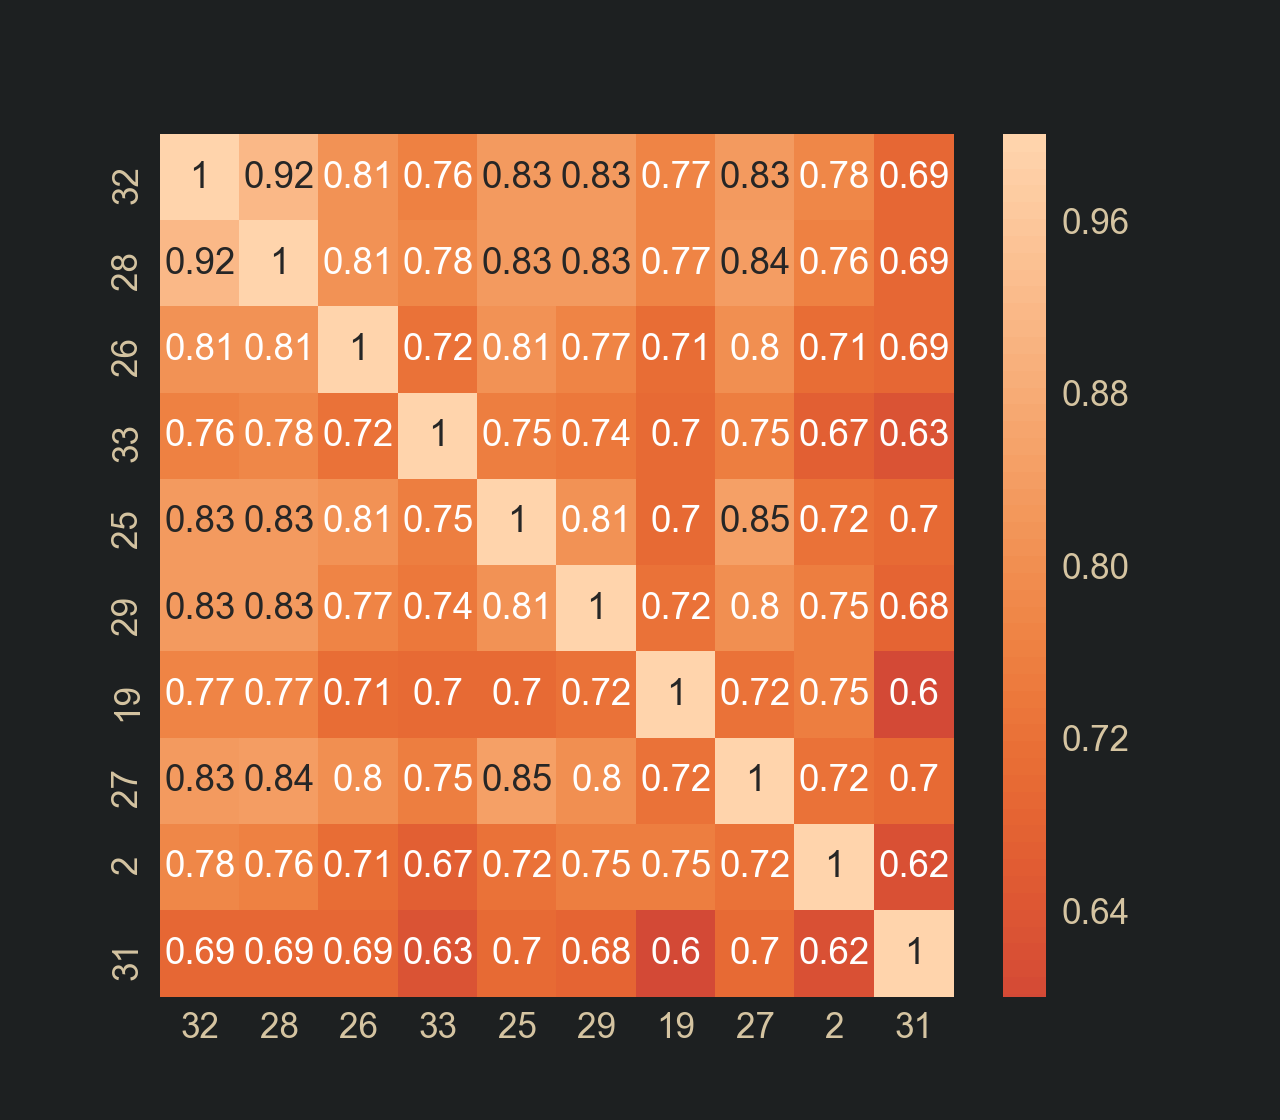

In [18]:
%matplotlib notebook

K_TOP = 10

top_results = {i: idx_results[i] for i in top.index[:K_TOP]}
ax = plot_corr_matrix(top_results)